In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import ParameterSampler
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pengaturan direktori dataset
train_dir = '/content/drive/MyDrive/sign language/train_vggnet'
validation_dir = '/content/drive/MyDrive/sign language/test_vggnet'

# Pengaturan ImageDataGenerator untuk augmentasi data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load dataset menggunakan flow_from_directory
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


In [ ]:
# Fungsi untuk membangun model dengan blok VGG16 yang dimodifikasi
def build_model(learning_rate=0.001, num_dense_units=256, filters_block1=64, filters_block2=128, filters_block3=256, filters_block4=512, filters_block5=572):
    # Define the VGG16 model architecture with custom filters
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Block 1
    x = Conv2D(filters_block1, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x = Conv2D(filters_block1, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(filters_block2, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(filters_block2, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(filters_block3, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(filters_block3, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(filters_block3, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(filters_block4, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(filters_block4, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(filters_block4, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(filters_block5, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(filters_block5, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(filters_block5, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Add custom layers on top of the VGG16 blocks
    x = Flatten()(x)
    x = Dense(num_dense_units, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(24, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Define the parameter grid for Random Search
param_grid = {
    'learning_rate': [0.001, 0.0001, 0.00001],
    'num_dense_units': [128, 256, 512],
    'filters_block1': [32, 64, 128],
    'filters_block2': [64, 128, 256],
    'filters_block3': [128, 256, 512],
    'filters_block4': [256, 512, 572],
    'filters_block5': [512, 572, 1024],
    'epochs': [20, 30, 40],
}

# Generate a list of parameter combinations
param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

# Initialize variables to track the best model and accuracy
best_accuracy = 0
best_params = None
best_model = None
best_history = None

# Initialize a list to store results
results = []

# Loop through each combination of parameters
for params in param_list:
    print(f"Training with params: {params}")
    model = build_model(
        learning_rate=params['learning_rate'],
        num_dense_units=params['num_dense_units'],
        filters_block1=params['filters_block1'],
        filters_block2=params['filters_block2'],
        filters_block3=params['filters_block3'],
        filters_block4=params['filters_block4'],
        filters_block5=params['filters_block5']
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=params['epochs'],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size
    )

    # Check if history is None or empty
    if not history.history:
        print("Training failed with params:", params)
        continue

    loss, accuracy = model.evaluate(validation_generator)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    # Store results
    results.append({
        'params': params,
        'accuracy': accuracy,
        'history': history
    })

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = model
        best_history = history


Training with params: {'num_dense_units': 512, 'learning_rate': 0.0001, 'filters_block5': 1024, 'filters_block4': 512, 'filters_block3': 256, 'filters_block2': 64, 'filters_block1': 64, 'epochs': 20}
Epoch 1/20
30/30 [==============================] - 27s 753ms/step - loss: 3.1786 - accuracy: 0.0396 - val_loss: 3.1759 - val_accuracy: 0.0417
Epoch 2/20
30/30 [==============================] - 21s 706ms/step - loss: 3.1493 - accuracy: 0.0510 - val_loss: 2.8660 - val_accuracy: 0.1354
Epoch 3/20
30/30 [==============================] - 23s 758ms/step - loss: 2.7449 - accuracy: 0.1688 - val_loss: 2.1566 - val_accuracy: 0.4167
Epoch 4/20
30/30 [==============================] - 22s 712ms/step - loss: 2.4061 - accuracy: 0.2250 - val_loss: 1.8236 - val_accuracy: 0.4271
Epoch 5/20
30/30 [==============================] - 22s 721ms/step - loss: 2.1375 - accuracy: 0.2990 - val_loss: 1.7765 - val_accuracy: 0.4583
Epoch 6/20
30/30 [==============================] - 23s 751ms/step - loss: 1.8403 - a

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results in a table
print(results_df[['params', 'accuracy']])

                                              params  accuracy
0  {'num_dense_units': 512, 'learning_rate': 0.00...  0.836066
1  {'num_dense_units': 512, 'learning_rate': 1e-0...  0.836066
2  {'num_dense_units': 128, 'learning_rate': 1e-0...  0.696721
3  {'num_dense_units': 256, 'learning_rate': 1e-0...  0.852459
4  {'num_dense_units': 256, 'learning_rate': 0.00...  0.040984
5  {'num_dense_units': 512, 'learning_rate': 0.00...  0.893443
6  {'num_dense_units': 256, 'learning_rate': 0.00...  0.040984
7  {'num_dense_units': 256, 'learning_rate': 0.00...  0.040984
8  {'num_dense_units': 256, 'learning_rate': 1e-0...  0.729508
9  {'num_dense_units': 128, 'learning_rate': 1e-0...  0.795082


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 64)        0   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Best Accuracy 
:  0.8934426307678223
Best Parameters 
: {'num_dense_units': 512, 'learning_rate': 0.0001, 'filters_block5': 572, 'filters_block4': 256, 'filters_block3': 512, 'filters_block2': 64, 'filters_block1': 64, 'epochs': 30}
4/4 [==============================] - 1s 175ms/step - loss: 0.2097 - accuracy: 0.8934
Validation Accuracy: 89.34%


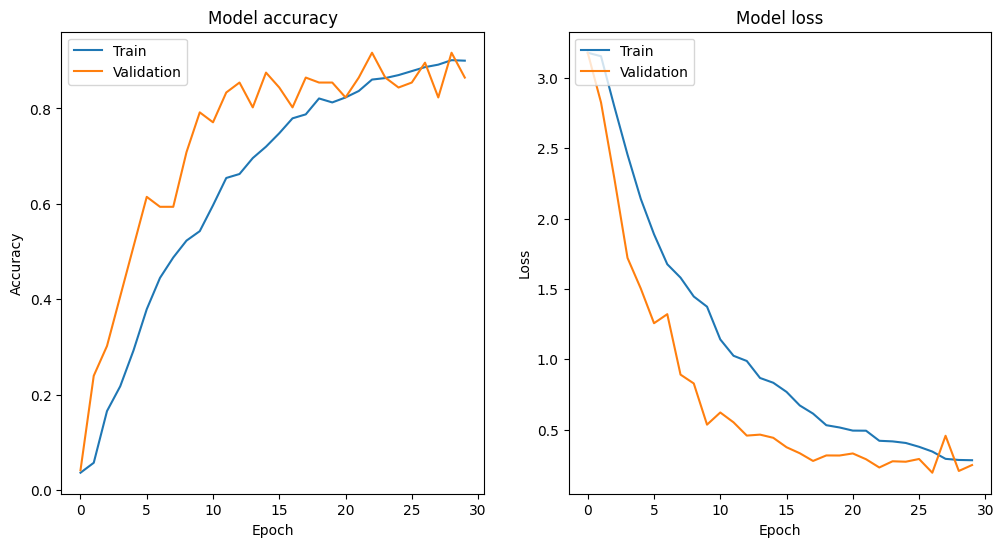

In [ ]:
# Save the best model
if best_model is not None:
    best_model.summary()
    best_model.save('vgg16_HyperparameterTune.h5')
    print("Best Accuracy \n: ",best_accuracy)
    print("Best Parameters \n:",best_params)
    # Evaluate the best model
    loss, accuracy = best_model.evaluate(validation_generator)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    # Visualize training history
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'])
    plt.plot(best_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'])
    plt.plot(best_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
else:
    print("No valid models were trained.")


In [ ]:
# Load model yang telah disimpan
model = load_model('/content/drive/MyDrive/sign language/vgg16_HyperparameterTune.h5')

# Pengaturan ImageDataGenerator untuk data uji
validation_dir = '/content/drive/MyDrive/sign language/test_vggnet'
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 1
test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,  # Set batch size ke 1 untuk prediksi individual
    class_mode='categorical',
    shuffle=False
)

In [ ]:
# Fungsi untuk melakukan prediksi dan menghitung akurasi per kelas
def calculate_class_accuracy(model, data_generator):
    y_true = data_generator.classes
    y_pred = model.predict(data_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    class_labels = list(data_generator.class_indices.keys())
    class_accuracies = {}

    for i, label in enumerate(class_labels):
        class_indices = np.where(y_true == i)[0]
        class_true = y_true[class_indices]
        class_pred = y_pred_classes[class_indices]
        class_accuracy = accuracy_score(class_true, class_pred)
        class_accuracies[label] = class_accuracy * 100  # Convert to percentage

    return class_accuracies

# Hitung akurasi per kelas untuk model yang telah di-load
vggnet_class_accuracies = calculate_class_accuracy(model, test_generator)

# Gabungkan hasil dalam bentuk tabel
results = {
    'Gesture': list(vggnet_class_accuracies.keys()),
    'VGGNet Recognition Correct Rate (%)': list(vggnet_class_accuracies.values())
}

df_results = pd.DataFrame(results)

1675/1675 [==============================] - 1079s 643ms/step


In [ ]:
# Hitung rata-rata correct rate
average_correct_rate = df_results['VGGNet Recognition Correct Rate (%)'].mean()

# Tampilkan tabel
print(df_results)

# Tampilkan rata-rata correct rate
print(f'\nAverage VGGNet Recognition Correct Rate: {average_correct_rate:.2f}%')

# Simpan tabel ke file CSV jika diperlukan
df_results.to_csv('gesture_recognition_results_vgg16_hyperparametertune.csv', index=False)

   Gesture  VGGNet Recognition Correct Rate (%)
0        a                            95.714286
1        b                            98.571429
2        c                           100.000000
3        d                            92.857143
4        e                            95.714286
5        f                           100.000000
6        g                            98.571429
7        h                            92.857143
8        i                            87.142857
9        k                            92.857143
10       l                           100.000000
11       m                            84.285714
12       n                            70.000000
13       o                            85.714286
14       p                           100.000000
15       q                           100.000000
16       r                           100.000000
17       s                            78.571429
18       t                            80.000000
19       u                            97